# Data Modeling

## New York Time Articles - Articles Clustering

### Goal of this notebook

> Cluster articles using pre-trained GloVe Word2Vec model and build Text Classifier based on produced cluster labels with XGBoostClassifier.

### Data Load

Import libraries.

In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# visualization and processing packages
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from src.paths import LOCAL_INTERIM_DATA_PATH, LOCAL_MODELS_PATH, LOCAL_PROCESSED_DATA_PATH

# custom packages for simplifing readibility of current notebook
from src.modeling.Loader import load_glove_model
from src.processing.DataNormalizer import remove_punctuation
from src.processing.IOController import load_normalized_nyt_df
from src.visualization.Plotter import plot_confusion_matrix, show_wordcloud
from src.processing.DataManipulator import get_most_correlated_tokens

# sklearn packages for machine learning / text classifier
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split, cross_val_score

tqdm.pandas()
pd.options.display.max_colwidth=300

C:\Users\muril\miniconda3\envs\ds-env\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Load consolidated DataFrame.

In [3]:
df = load_normalized_nyt_df(LOCAL_INTERIM_DATA_PATH / 'nyt-articles-consolidated.csv')
df.head(2).T

,0,1
abstract,"A Times video investigation identified Chinese companies using a contentious labor program for Uighurs to satisfy demand for P.P.E., some of which ended up in the United States and other countries.",Anger at lockdowns and mask mandates provides fertile ground for arguments about the best way to fight the virus.
web_url,https://www.nytimes.com/2020/07/19/world/asia/china-mask-forced-labor.html,https://www.nytimes.com/2020/07/19/business/media/coronavirus-contrarians-lockdowns-masks.html
snippet,"A Times video investigation identified Chinese companies using a contentious labor program for Uighurs to satisfy demand for P.P.E., some of which ended up in the United States and other countries.",Anger at lockdowns and mask mandates provides fertile ground for arguments about the best way to fight the virus.
lead_paragraph,"As the coronavirus pandemic continues to drive demand for personal protective equipment, Chinese companies are rushing to manufacture the gear for domestic and global consumption. A New York Times visual investigation has found that some of those companies are using Uighur labor through a conten...","COLUMBUS, Ohio — If you’ve been following Gov. Mike DeWine’s coronavirus news conferences the way that New Yorkers follow Andrew Cuomo’s, you know Jack Windsor: He’s the reporter asking about creeping Marxism among contact tracers and suggesting that Ohio is double counting virus cases."
source,The New York Times,The New York Times
multimedia,[],"[{'rank': 0, 'subtype': 'xlarge', 'caption': None, 'credit': None, 'type': 'image', 'url': 'images/2020/07/19/business/19BenSmith-01/19BenSmith-01-articleLarge.jpg', 'height': 400, 'width': 600, 'legacy': {'xlarge': 'images/2020/07/19/business/19BenSmith-01/19BenSmith-01-articleLarge.jpg', 'xlar..."
headline,"{'main': 'China Is Using Uighur Labor to Produce Face Masks', 'kicker': None, 'content_kicker': None, 'print_headline': None, 'name': None, 'seo': None, 'sub': None}","{'main': 'An Ex-Times Reporter. An Ohio Wedding Provider. Covid Contrarians Go Viral.', 'kicker': 'the media equation', 'content_kicker': None, 'print_headline': 'Lockdown Anger Provides Fertile Ground for Virus Contrarians', 'name': None, 'seo': None, 'sub': None}"
keywords,"[{'name': 'subject', 'value': 'Uighurs (Chinese Ethnic Group)', 'rank': 1, 'major': 'N'}, {'name': 'subject', 'value': 'Forced Labor', 'rank': 2, 'major': 'N'}, {'name': 'subject', 'value': 'Coronavirus (2019-nCoV)', 'rank': 3, 'major': 'N'}, {'name': 'glocations', 'value': 'China', 'rank': 4, '...","[{'name': 'subject', 'value': 'Coronavirus (2019-nCoV)', 'rank': 1, 'major': 'N'}, {'name': 'persons', 'value': 'Berenson, Alex', 'rank': 2, 'major': 'N'}, {'name': 'persons', 'value': 'Windsor, Jack (1976- )', 'rank': 3, 'major': 'N'}, {'name': 'subject', 'value': 'News and News Media', 'rank':..."
pub_date,2020-07-19 20:00:09+00:00,2020-07-20 00:30:07+00:00
document_type,article,article


### Data Preprocessing

Remove data with missing `abstract`

> Remove missing data and reindexing are necessary. Ideally this should be done at the extracting / preprocessing notebooks, but for simplicity purposes we are doing it here.

In [4]:
df = df[df.abstract.notna()]
allowed_labels = df.news_desk.value_counts().where(lambda x: x > 100).dropna().index
df = df[df.news_desk.isin(allowed_labels)]
df = df.reset_index().drop('index', axis=1)

Load pretrained Word2Vec Model.

> Here we're using a simple GloVe model it contains 400,000 vocabulary vectors with 50 dimensions each (reference [link](https://nlp.stanford.edu/projects/glove/)). It's the smallest one available for us to start testing. Let's have a look on the vectors themselves, they are numpy array with 50 float points each. Based on that we can cluster the articles!

In [127]:
glove_path = LOCAL_PROCESSED_DATA_PATH / 'glove.6B.50d.txt'
glove_vectors = load_glove_model(glove_path)
glove_vectors['man'], glove_vectors['woman']

(array([-0.094386,  0.43007 , -0.17224 , -0.45529 ,  1.6447  ,  0.40335 ,
        -0.37263 ,  0.25071 , -0.10588 ,  0.10778 , -0.10848 ,  0.15181 ,
        -0.65396 ,  0.55054 ,  0.59591 , -0.46278 ,  0.11847 ,  0.64448 ,
        -0.70948 ,  0.23947 , -0.82905 ,  1.272   ,  0.033021,  0.2935  ,
         0.3911  , -2.8094  , -0.70745 ,  0.4106  ,  0.3894  , -0.2913  ,
         2.6124  , -0.34576 , -0.16832 ,  0.25154 ,  0.31216 ,  0.31639 ,
         0.12539 , -0.012646,  0.22297 , -0.56585 , -0.086264,  0.62549 ,
        -0.0576  ,  0.29375 ,  0.66005 , -0.53115 , -0.48233 , -0.97925 ,
         0.53135 , -0.11725 ]),
 array([-1.8153e-01,  6.4827e-01, -5.8210e-01, -4.9451e-01,  1.5415e+00,
         1.3450e+00, -4.3305e-01,  5.8059e-01,  3.5556e-01, -2.5184e-01,
         2.0254e-01, -7.1643e-01,  3.0610e-01,  5.6127e-01,  8.3928e-01,
        -3.8085e-01, -9.0875e-01,  4.3326e-01, -1.4436e-02,  2.3725e-01,
        -5.3799e-01,  1.7773e+00, -6.6433e-02,  6.9795e-01,  6.9291e-01,
        -2.

Calculate Doc2Vec.

> Based on the text of each article here the abstract has it's words looped and an average of all present vectors is taken to produce a document vector for each article. This model will be tested for our clustering further along.

In [156]:
w2v_features = pd.DataFrame(
               df.abstract\
                 .apply(remove_punctuation)\
                 .str.split()\
                 .apply(lambda words: [glove_vectors[w] for w in words if w in vecs.keys()])\
                 .apply(lambda x: pd.DataFrame(x)\
                 .mean())\
                 .to_numpy()
                ).fillna(0)
print('50 Dimension Document Vector per NYT Article')
w2v_features

50 Dimension Document Vector per NYT Article


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.326589,-0.017240,0.045586,0.041758,0.142576,0.311684,-0.466416,-0.286942,0.053506,0.013022,...,-0.244421,0.041602,0.205134,0.112239,0.003888,-0.016592,-0.239759,0.277444,-0.122222,-0.172170
1,0.364144,0.039924,-0.167337,-0.038591,0.123295,0.102689,-0.188105,-0.174027,0.180201,0.000986,...,-0.154470,-0.012439,0.096603,0.316492,0.000609,0.097296,0.127635,0.021714,-0.145475,-0.050793
2,0.617842,-0.046274,0.021756,-0.113315,0.270286,0.474606,-0.346578,-0.150358,0.014951,-0.063330,...,-0.408287,0.126702,0.233165,0.250144,0.274912,0.108317,-0.216270,0.059530,-0.087128,-0.293858
3,0.440729,0.192605,-0.016803,-0.002940,0.186979,0.130058,-0.361378,-0.074633,0.111185,-0.133481,...,-0.285765,-0.049622,0.075889,-0.101266,-0.084127,0.161413,-0.056787,0.114525,-0.149538,-0.194851
4,-0.059624,0.177270,-0.129861,0.246976,0.302623,0.241254,-0.352079,-0.042261,-0.209124,-0.454381,...,-0.440779,0.243835,-0.361602,-0.095633,-0.324161,0.222049,-0.515664,-0.112394,0.211890,0.069408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20503,0.386906,0.199528,-0.095980,-0.130156,0.479489,0.123001,-0.185976,-0.123423,-0.148289,-0.102550,...,-0.233593,0.023021,0.120721,0.157460,-0.175831,0.029285,-0.209529,0.010338,0.008272,-0.137759
20504,0.687646,0.053401,0.056943,0.020350,0.583154,0.387594,-0.246897,0.012852,-0.087479,-0.216698,...,-0.242547,0.022291,0.088507,0.217401,-0.058251,-0.211626,-0.456559,0.348293,0.159432,-0.388623
20505,0.227769,0.123679,-0.128739,-0.088676,0.351434,0.436246,-0.270486,-0.243246,-0.073302,-0.069816,...,-0.192667,0.135690,-0.254466,0.031627,-0.248787,0.070486,-0.198222,0.026854,0.009366,0.009827
20506,0.315609,0.066648,0.305979,-0.341993,0.546829,-0.069764,-0.244409,-0.281611,-0.231242,0.355544,...,-0.492422,-0.093705,0.100319,0.232707,0.018416,-0.063014,0.444747,0.578288,0.284850,-0.114271


Compare `close` related articles.

> Here we're doing another simplification, which is to take the average of each document vector and sort the resulting data. The idea is to have a preliminary feel if the Doc2Vec has indeed captured some structure. That's prior to reducing dimensionality, which we're doing with t-SNE on the next steps. But it sure does to have brought some structure to the data, we can see Foreign matters close to each other with mentionings about brutal austerity, liberation of Auschwitz and facist. Same thing on the over side by Science, were the subjects do seem to be correlated.

In [158]:
print('Top and Bottom 5 Most Related Abstracts - GloVe Doc2Vec Model')
df['word2vec_avg'] = pd.DataFrame(w2v_features).fillna(0).mean(axis=1).fillna(0)
df.sort_values('word2vec_avg')[['abstract','news_desk', 'word2vec_avg']]

Top and Bottom 5 Most Related Abstracts - GloVe Doc2Vec Model


,abstract,news_desk,word2vec_avg
8143,"After a decade of brutal austerity, a center-right party defeated Prime Minister Alexis Tsipras’s leftist Syriza party.",Foreign,-0.122619
3536,World leaders converged in Jerusalem to mark the 75th anniversary of the liberation of Auschwitz.,Foreign,-0.118741
11230,"Prime Minister Imran Khan denounced India’s military clampdown in Muslim-majority Kashmir, attributing it to a “racist, fascist, Hindu supremacist mind-set.”",Foreign,-0.109601
6939,Results from the Alaska presidential primary election.,U.S.,-0.105001
1166,Live Stock Market News During the Coronavirus Pandemic,Business,-0.104792
...,...,...,...
11996,"The tests often are positive in people without symptoms, particularly older patients. The result: overtreatment with antibiotics.",Science,0.114887
444,Thank goodness for crummy video conferencing.,Business,0.118789
6272,"To keep coronavirus patients breathing, hospitals are pioneering a little-tested method.",Science,0.128345
1880,"You’ve had six-minute eggs, maybe slow-cooked eggs. Now try an egg cooked forever.",Science,0.130176


Reduce dimensionality

> For a proper visualization of these vectors we are going to reduce dimensionality via t-SNE. The ideia is to decompose the vectors dimension until it reaches 2, so we can do a simple scatterplot and them visualize our clusters and labels. Take a look at the result vectors on the temporary dataframe.

In [135]:
%%time
w2v_features_2d = TSNE(n_components=2).fit_transform(w2v_features)
tmp = pd.DataFrame(w2v_features_2d).rename({0: 'w2v_x', 1: 'w2v_y'}, axis=1)
df = df.join(tmp)
tmp

Wall time: 4min 20s


,w2v_x,w2v_y
0,-2.616439,-34.908302
1,-38.197655,16.856529
2,-12.750084,-14.121419
3,-3.041323,0.387514
4,29.590593,1.535496
...,...,...
20503,-23.721199,25.736526
20504,4.896863,-14.739761
20505,20.412373,4.035093
20506,-25.246687,-43.852463


Cluster document vectors.

> Here we're having two approaches with DBSCAN and K-Means. The idea is to compare the clusters and see if they extract some structure for building mode customized classifier.

In [ ]:
%%time
df['dbscan_clusters'] = DBSCAN(eps=0.1, min_samples=5, metric='euclidean').fit_predict(w2v_features.to_numpy())

In [32]:
%%time
df['kmeans_clusters'] = KMeans(n_clusters=6).fit_predict(w2v_features.to_numpy())

Wall time: 895 ms


Visualize clusters.

> Here we can compare our current labels to the new clusters and see if they make sense. Now visually we can attest the vectors bring promising results. Since the label are really clustered into regions. Let's check the artificially generated clusters.

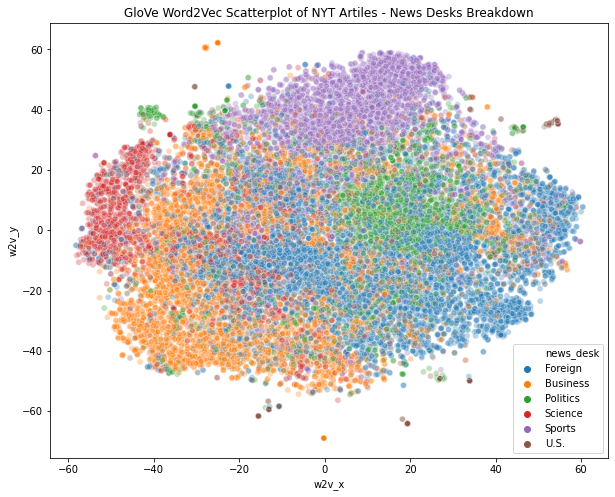

In [109]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='w2v_x', y='w2v_y', hue='news_desk', data=df, alpha=.3)
plt.title(f'GloVe Word2Vec Scatterplot of NYT Artiles - News Desks Breakdown')
plt.show()

Check K-Means.

> K-Means clustering uses a pre-defined amount of clusters, so here I've set it to 6 which is the same number of news desks. Visually we can see that some structures, specially after crossing it with the visualization above of the news desks. Cluster 0, 2 and 4 seem to be very correlated to Business, Sports and Science, respectivelly. Below we're gonna have a deeper dive in and check some of these articles and word clouds.

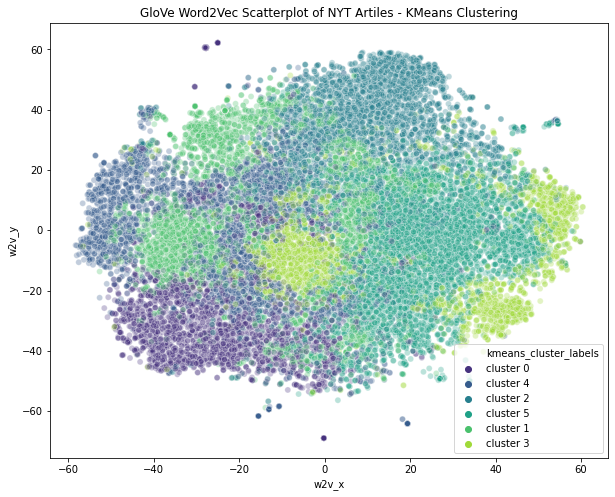

In [163]:
cluster_id_to_label = {i: f'cluster {i}' for i in df['kmeans_clusters'].unique()}
df['kmeans_cluster_labels'] = df['kmeans_clusters'].map(cluster_id_to_label)

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='w2v_x', y='w2v_y', hue='kmeans_cluster_labels', data=df, palette='viridis', alpha=.3)
plt.title(f'GloVe Word2Vec Scatterplot of NYT Artiles - KMeans Clustering')
plt.show()

Check DBScan.

> DBScan is an works with the epsilon parameters which sets a circuference for separating clusters. In these case I've testet if from 0.1 up to 3.0 with very little results. The majority of posts are kept on the same cluster. For now we're gonna leave it aside and move on with k-means which already has some promising results.

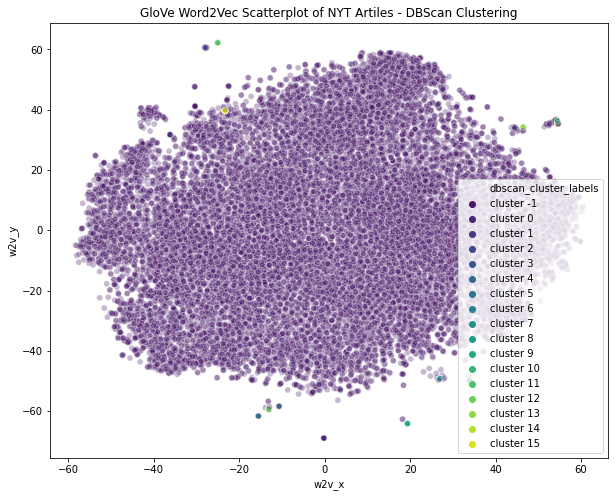

In [160]:
cluster_id_to_label = {i: f'cluster {i}' for i in df['dbscan_clusters'].unique()}
df['dbscan_cluster_labels'] = df['dbscan_clusters'].map(cluster_id_to_label)

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='w2v_x', y='w2v_y', hue='dbscan_cluster_labels', data=df, palette='viridis', alpha=.3)
plt.title(f'GloVe Word2Vec Scatterplot of NYT Artiles - DBScan Clustering')
plt.show()

Check word correlation of each cluster.

> More insights can be drawn again using Chi Squared, thanks to it's capability to extract correlation amongts features. In this case we start to find some structs, so I would name each cluster as follows:
> * `cluster 0`: Business
> * `cluster 1`: American Politics
> * `cluster 2`: Sports
> * `cluster 3`: National Security & Warfare
> * `cluster 4`: Science
> * `cluster 5`: Foreing Politics 


In [210]:
cluster_to_subject = {
    0: 'Business',
    1: 'American Politics',
    2: 'Sports',
    3: 'National Security & Warfare',
    4: 'Science',
    5: 'Foreign Politics',
}

subject_to_cluster = {v: k for k,v in cluster_to_subject.items()}

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(df.abstract).toarray()
get_most_correlated_tokens(features, df['kmeans_clusters'], tfidf, subject_to_cluster, top_n_tokens=5)

,1-grams,2-grams,3-grams
American Politics,"[think, make, say, want, know]","[busy week, week american, politics stories, stories missed, need know]","[light night skies, busy week american, american politics stories, politics stories missed, week american politics]"
Business,"[transactions, company, stock, billion, market]","[commercial real, recent commercial, estate transactions, transactions new, real estate]","[commercial real estate, real estate transactions, recent commercial real, transactions new york, estate transactions new]"
Foreign Politics,"[party, prime, election, minister, president]","[times sent, sent survey, president trump, vice president, prime minister]","[limits presidential authority, presidential authority wield, candidates understanding scope, understanding scope limits, times sent survey]"
National Security & Warfare,"[officers, died, attack, police, killed]","[security forces, police said, police officers, officials said, people killed]","[mosques new zealand, nazanin zaghari ratcliffe, death toll rose, easter sunday bombings, year old girl]"
Science,"[researchers, county, study, coronavirus, scientists]","[cases county, outbreak tables, detailed county, extent coronavirus, shows extent]","[number cases county, outbreak tables number, coronavirus outbreak tables, shows extent coronavirus, extent coronavirus outbreak]"
Sports,"[league, championship, game, team, season]","[regular season, super bowl, world series, grand slam, world cup]","[new orleans pelicans, united states open, 15 year old, year old american, college football playoff]"


Plot cluster Word Clouds.

> Having a broader look we can get a feeling if each subject do really correspond to the proposed subjects. For starters I would leave it as is, but here a deeper time should be spend understand the clusters and even trying out new parameters for our algorithms to test the outcome.

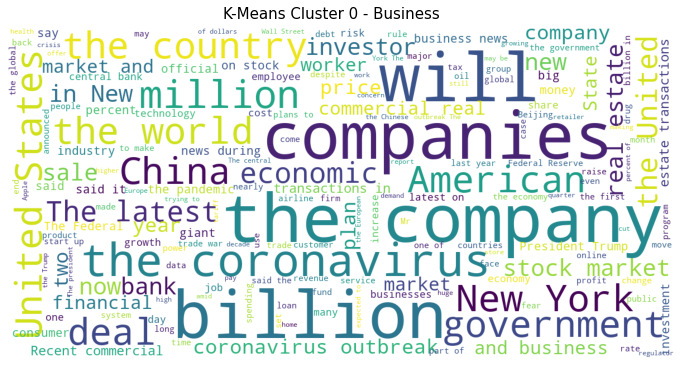

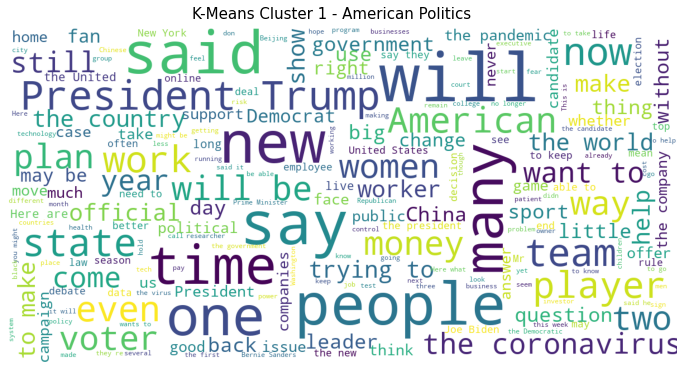

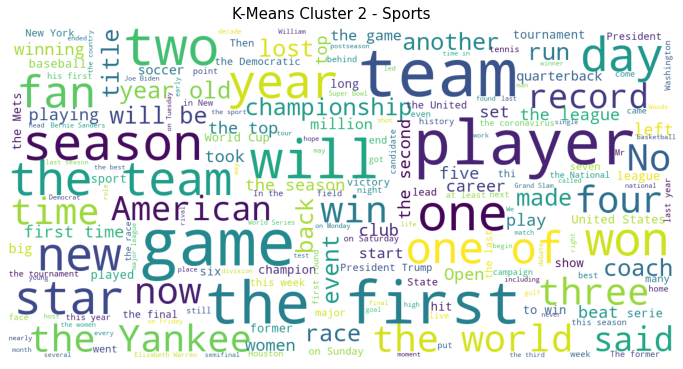

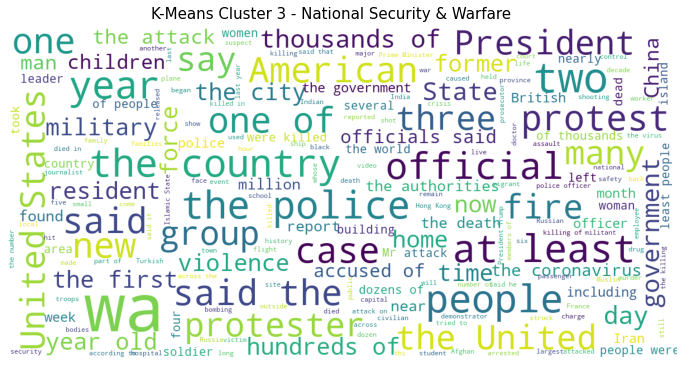

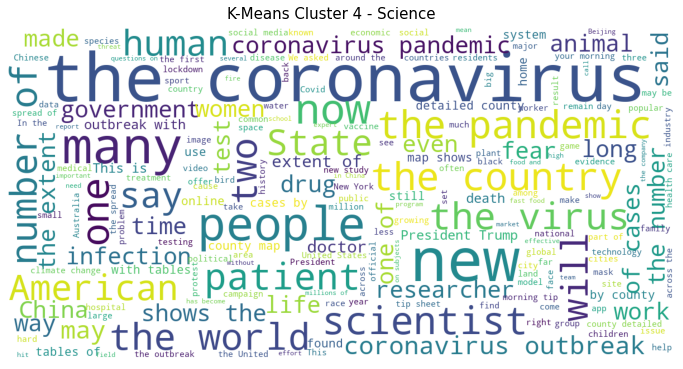

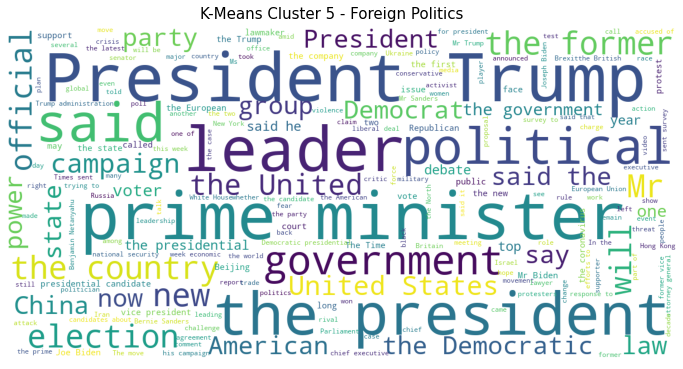

In [188]:
for cluster in sorted(df.kmeans_clusters.unique()):
    mask = df.kmeans_clusters == cluster
    txt = ' '.join(df[mask].abstract.tolist())
    show_wordcloud(txt, title=f'K-Means Cluster {cluster} - {cluster_to_subject[cluster]}')

Check article abstracts of each cluster.

> Again, the clusters do seem to make sense. Let's keep it for now!

In [192]:
for cluster in sorted(df.kmeans_clusters.unique()):
    print(f'Cluster {cluster} Articles - {cluster_to_subject[cluster]}')
    display(df[df.kmeans_clusters == cluster][['abstract', 'news_desk']].head(3))

Cluster 0 Articles - Business


,abstract,news_desk
0,"A Times video investigation identified Chinese companies using a contentious labor program for Uighurs to satisfy demand for P.P.E., some of which ended up in the United States and other countries.",Foreign
15,"With a $5 billion play for Noble Energy, the oil giant is set to acquire properties around the world for a relative bargain. Other companies might make similar moves.",Business
16,"Many of the nation’s business leaders are steeling themselves for a period of prolonged economic disruption and the prospect of a slow, halting recovery.",Business


Cluster 1 Articles - American Politics


,abstract,news_desk
6,"Experts say one popular test that the president might have taken is by no means definitive, or even diagnostic.",Science
8,Black creative professionals say they have been used to lend legitimacy to diversity campaigns while being underpaid and pigeonholed.,Business
20,"President Trump continues to press for a quick return to life as usual, but Republicans who fear a rampaging disease and angry voters are increasingly going their own way.",Politics


Cluster 2 Articles - Sports


,abstract,news_desk
3,"Top Republicans met with President Trump to smooth the way on negotiations for the next round of virus aid. India recorded at least 40,000 new infections on Monday, its highest single-day total.",Foreign
9,"Major League Baseball will hold its delayed opening day this week, with no fans. In four American cities, though, professional baseball has already returned, pressing ahead in a season like no other.",Sports
12,The team’s move to Canada to train and finish the N.H.L. season recalls a time in the 1960s and ’70s when training up there was standard. And most of the team was Canadian.,Sports


Cluster 3 Articles - National Security & Warfare


,abstract,news_desk
11,"Rescuers continue to pull the bodies of victims from Lake Van, in eastern Turkey, more than three weeks after the fishing boat carrying them sank.",Foreign
24,"The vehicle, with 27 people on board, was specially designed to carry visitors onto one of North America’s largest glaciers, in Jasper National Park in Alberta.",Foreign
49,The Indian authorities arrested dozens of people during a nationwide lockdown. Human rights groups say many of the detentions are based on scant evidence.,Foreign


Cluster 4 Articles - Science


,abstract,news_desk
1,Anger at lockdowns and mask mandates provides fertile ground for arguments about the best way to fight the virus.,Business
2,"Doctors are seeing more cases a day than they had in previous outbreaks, and a number of infections with unknown origin have made the outbreak harder to contain.",Foreign
7,Public health experts say delays in testing continue to hinder attempts to track and contain the spread of disease.,Science


Cluster 5 Articles - Foreign Politics


,abstract,news_desk
4,"Ms. Williams, the state party chairwoman and a state senator, is considered the overwhelming favorite in the general election this fall.",Politics
5,Tensions are running high in the country amid a national debate on racial profiling in police ranks.,Foreign
14,"Mr. Biden is running a risk-averse campaign in states like Wisconsin, where a broad coalition of supporters is emerging. Even Republicans are noticing.",Politics


Train a text classifier.

> Now that we do have our article in neat clusters, we can generalize this solution into a Text Classifier. The proposal is to bring the cluster embeddings into a model that can predict if a given text belongs to a specific cluster. For that we'll do no Model Selection, but instead try a very popular algorithm, `xgboost`. Let's see what it produces.

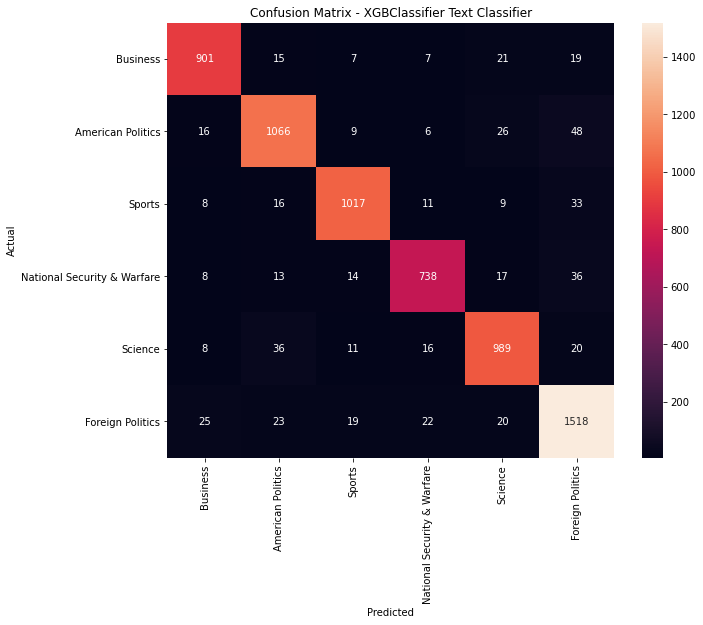

In [197]:
model, c_matrix, y_test, y_pred, indices_test = plot_confusion_matrix(XGBClassifier(), df, w2v_features, df.kmeans_clusters, subject_to_cluster)

Check model performance.

> Wow, much better results than our supervised model. In this case the structures embedded in our clustering seem to have produced better labels than manual ones. If the average accuracy of 92% is good enough or not, it depends on the application and business requirements, but for sure we have a much better quantitative result in this case. Looks promising for future applications if the labels are indeed interesting from a business point of view.

In [209]:
print(metrics.classification_report(y_test, y_pred, target_names=df['kmeans_clusters'].map(cluster_to_subject).unique()))

                             precision    recall  f1-score   support

                   Business       0.93      0.93      0.93       970
                    Science       0.91      0.91      0.91      1171
                     Sports       0.94      0.93      0.94      1094
           Foreign Politics       0.92      0.89      0.91       826
          American Politics       0.91      0.92      0.91      1080
National Security & Warfare       0.91      0.93      0.92      1627

                   accuracy                           0.92      6768
                  macro avg       0.92      0.92      0.92      6768
               weighted avg       0.92      0.92      0.92      6768

